In [49]:
import numpy as np 
import pandas as pd 
import os
import glob
import cv2
import random
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, Activation
from keras.models import Model, Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.models import load_model
from keras.utils import np_utils
from keras import backend as K

PATH = "../input/cell-images-for-detecting-malaria/cell_images/cell_images/"
print(os.listdir(PATH))

['Parasitized', 'Uninfected']


 * https://github.com/keras-team/keras/issues/5400

In [50]:
# all image path of parasitized
paths_para=glob.glob(os.path.join(PATH,'Parasitized','*.png'))
paths_uninf=glob.glob(os.path.join(PATH,'Uninfected','*.png'))
len(paths_para), len(paths_uninf)

(13779, 13779)

In [51]:
# show one
path=paths_para[0]
img=cv2.imread(path) # cv2 stores image in BGR format
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB) # transforming to RGB format
img.shape

(130, 118, 3)

In [52]:
# helper to get images
def get_data(path, resize_dim=96):
    img=cv2.imread(path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img_rz=cv2.resize(img,(resize_dim,resize_dim),interpolation=cv2.INTER_AREA)
    return img_rz

## Get the data

In [53]:
parasite_images=np.array([get_data(path) for path in paths_para])
parasite_images.shape

(13779, 96, 96, 3)

In [54]:
uninf_images=np.array([get_data(path) for path in paths_uninf])
uninf_images.shape

(13779, 96, 96, 3)

## Make labels

In [55]:
para_label = np.array([1 for _ in range(len(parasite_images))])
uninf_label = np.array([0 for _ in range(len(uninf_images))])

para_label.shape, uninf_label.shape

((13779,), (13779,))

## Data set initialize

In [56]:
x_all = np.concatenate((parasite_images, uninf_images), axis=0)
y_all = np.concatenate((para_label, uninf_label), axis=0)
print(x_all.shape, y_all.shape)

#train = shuffle(train, random_state=123)

(27558, 96, 96, 3) (27558,)


## Show an image

Index number: 9935
Label: 1


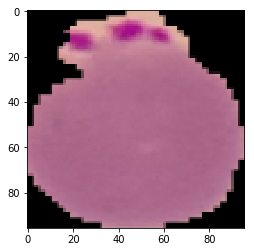

In [57]:
idx = random.randint(0, len(x_all))
print("Index number: {}".format(idx))
print("Label: {}".format(y_all[idx]))
plt.imshow(x_all[idx])

## Show many images

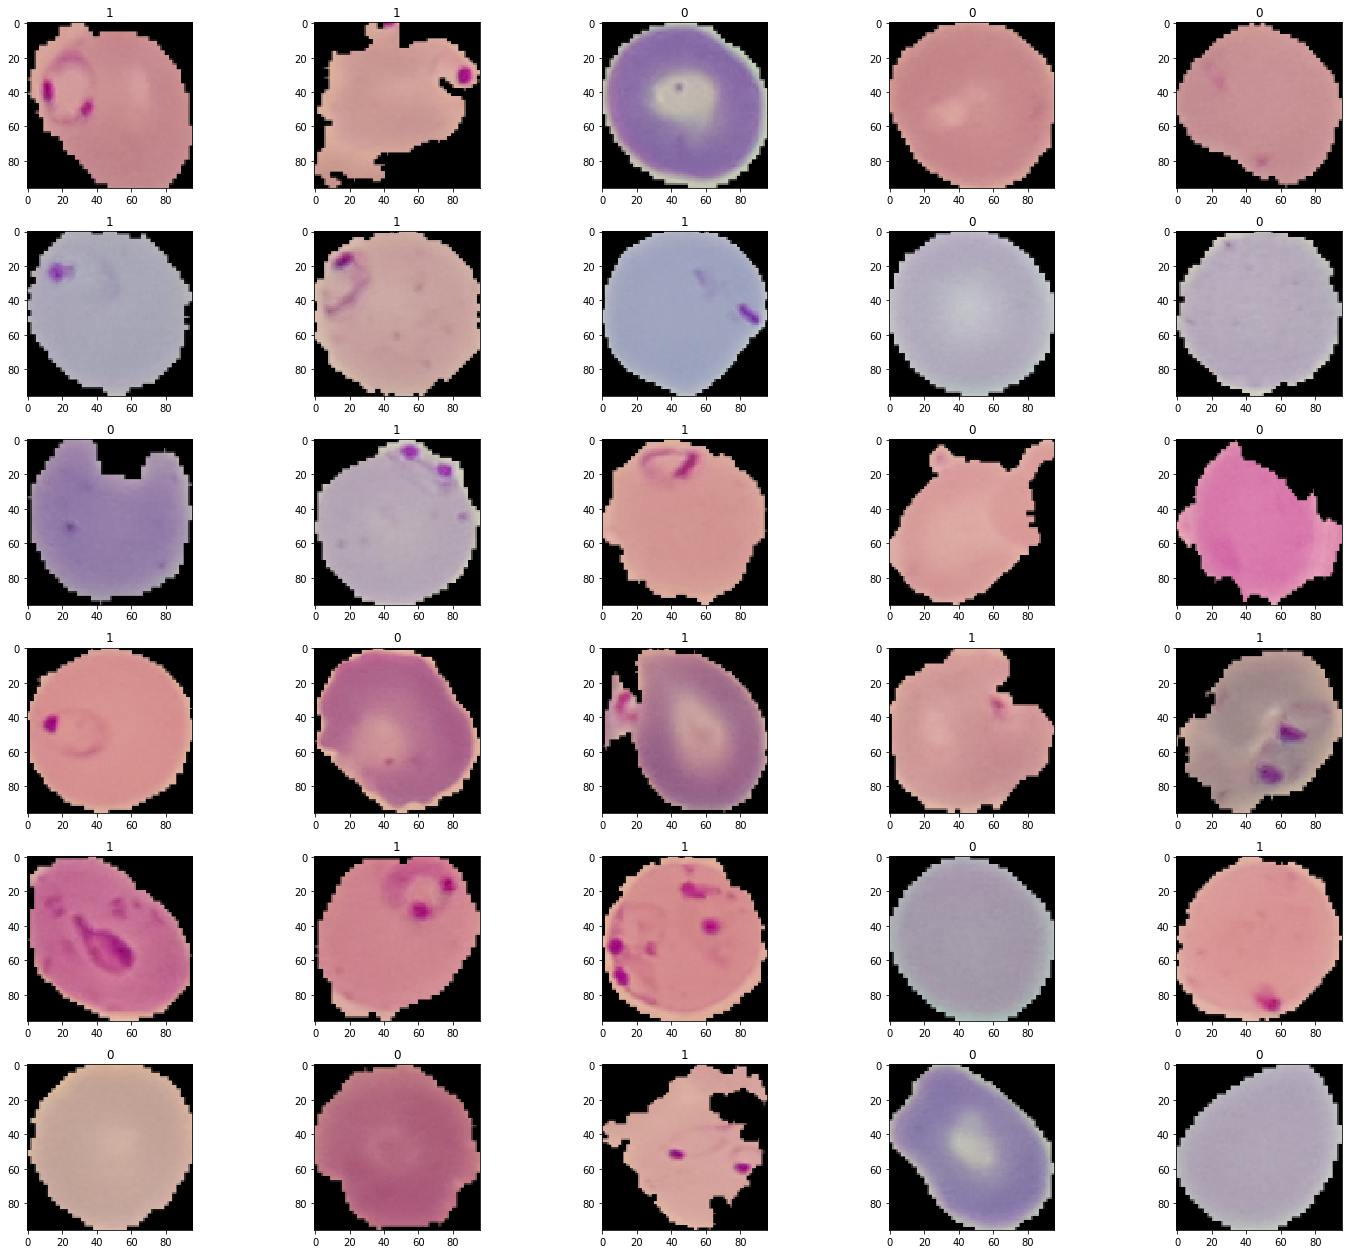

In [58]:
plt.figure(figsize=(20,20))
columns = 5

lower = 0
upper = 30 

for i in range(upper):
    ax = plt.subplot(upper / columns + 1, columns, i + 1)
    idx = random.randint(0, len(x_all))
    ax.set_title(y_all[idx])
    plt.imshow(x_all[idx], cmap='gray') # binary
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

## Make training and testing sets

In [107]:
indices=list(range(len(x_all)))
np.random.seed(42)
np.random.shuffle(indices)

ind=int(len(indices)*0.95)
# train data
input_features=x_all[indices[:ind]] 
labels=y_all[indices[:ind]]
# validation data
x_test=x_all[indices[-(len(indices)-ind):]] 
y_test=y_all[indices[-(len(indices)-ind):]]

In [108]:
print(input_features.shape, labels.shape)
print(x_test.shape, y_test.shape)

(26180, 96, 96, 3) (26180,)
(1378, 96, 96, 3) (1378,)


## Define network

In [65]:
def first():
    input_shape = (96, 96, 3)
    model = Sequential()
    model.add(Conv2D(32, 3, 3, border_mode='same', input_shape=input_shape, activation='relu'))
    model.add(Conv2D(32, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(Conv2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(Conv2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy',
                optimizer=optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0), #RMSprop(lr=0.0001) #deafult LR=0.001
                metrics=['accuracy'])
                # metrics=[mcor,recall, f1]
    return model

In [66]:
model=first()
model.summary()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(96, 96, 3..., activation="relu", padding="same")`
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", padding="same")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 128)       73856     
__________

In [109]:
x_train, x_val, y_train, y_val = train_test_split(input_features, labels, test_size=0.1, random_state=1)
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(23562, 96, 96, 3) (2618, 96, 96, 3) (23562,) (2618,)


In [69]:
model.fit(x_train, y_train,
          batch_size=32,
          epochs=20,
          verbose=1,
          validation_data=(x_val, y_val))

print("Done training...")

Train on 23562 samples, validate on 2618 samples
Epoch 1/20
23562/23562 [==============================] - 52s 2ms/step - loss: 0.3583 - acc: 0.8303 - val_loss: 0.1549 - val_acc: 0.9488
Epoch 2/20
23562/23562 [==============================] - 50s 2ms/step - loss: 0.1515 - acc: 0.9542 - val_loss: 0.1438 - val_acc: 0.9545
Epoch 3/20
23562/23562 [==============================] - 50s 2ms/step - loss: 0.1369 - acc: 0.9582 - val_loss: 0.1741 - val_acc: 0.9458
Epoch 4/20
23562/23562 [==============================] - 50s 2ms/step - loss: 0.1304 - acc: 0.9592 - val_loss: 0.1922 - val_acc: 0.9557
Epoch 5/20
23562/23562 [==============================] - 50s 2ms/step - loss: 0.1268 - acc: 0.9613 - val_loss: 0.1512 - val_acc: 0.9568
Epoch 6/20
23562/23562 [==============================] - 50s 2ms/step - loss: 0.1273 - acc: 0.9596 - val_loss: 0.1366 - val_acc: 0.9561
Epoch 7/20
23562/23562 [==============================] - 50s 2ms/step - loss: 0.1246 - acc: 0.9623 - val_loss: 0.2394 - val_acc:

In [70]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.12058413857580616
Test accuracy: 0.967343976777939


In [71]:
'''
80-10% 10% split -> 
Test loss: 0.12058413857580616
Test accuracy: 0.967343976777939
'''

'\n80-10% 10% split -> \nTest loss: 0.12058413857580616\nTest accuracy: 0.967343976777939\n'

# Transfer Learning

In [110]:
# model with ALL layers frozen, except for the SOFTMAX layer
def vgg16():
    base_model = VGG16(weights='../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',include_top=False,pooling='avg',input_shape=(96, 96, 3))
    base_model.trainable = False
    X = base_model.output
    X.trainable = False
    # softmax layer
    predictions = Dense(2, activation='softmax')(X)
    
    # magical line of freezing layers
    #for layer in base_model.layers[:-5]:
        #layer.trainable=False

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model=vgg16()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 96, 96, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0         
__________

In [111]:
# check input
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(23562, 96, 96, 3) (23562,) (2618, 96, 96, 3) (2618,)


In [112]:
# one hot encoded vectors
num_classes = 2

y_train = np_utils.to_categorical(y_train,num_classes)
y_val = np_utils.to_categorical(y_val,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)
print(y_train.shape, y_val.shape, y_test.shape)

(23562, 2) (2618, 2) (1378, 2)


In [113]:
# check input
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(23562, 96, 96, 3) (23562, 2) (2618, 96, 96, 3) (2618, 2)


In [114]:
model=vgg16()
path_model='vgg16.h5'  

# set the learning rate
K.set_value(model.optimizer.lr,1e-2) 

h=model.fit(x=x_train,     
            y=y_train, 
            batch_size=64, 
            epochs=20, 
            verbose=1, 
            validation_data=(x_val,y_val),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
            ]
            )


Train on 23562 samples, validate on 2618 samples
Epoch 1/20
23562/23562 [==============================] - 143s 6ms/step - loss: 0.2187 - acc: 0.9342 - val_loss: 0.1356 - val_acc: 0.9542
Epoch 2/20
23562/23562 [==============================] - 138s 6ms/step - loss: 0.1037 - acc: 0.9640 - val_loss: 0.1184 - val_acc: 0.9584
Epoch 3/20
23562/23562 [==============================] - 138s 6ms/step - loss: 0.0826 - acc: 0.9714 - val_loss: 0.1134 - val_acc: 0.9607
Epoch 4/20
23562/23562 [==============================] - 138s 6ms/step - loss: 0.0647 - acc: 0.9770 - val_loss: 0.1131 - val_acc: 0.9618
Epoch 5/20
23562/23562 [==============================] - 138s 6ms/step - loss: 0.0489 - acc: 0.9832 - val_loss: 0.1163 - val_acc: 0.9618
Epoch 6/20
23562/23562 [==============================] - 138s 6ms/step - loss: 0.0384 - acc: 0.9866 - val_loss: 0.1354 - val_acc: 0.9614
Epoch 7/20
23562/23562 [==============================] - 138s 6ms/step - loss: 0.0286 - acc: 0.9899 - val_loss: 0.1332 - v

In [115]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2520520506224386
Test accuracy: 0.9680696661828737


In [124]:
def plot_loss_accu(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'g')
    plt.plot(epochs, val_loss, 'y')
    plt.title('Training and validation loss')
    plt.legend(['train', 'val'], loc='upper right')
    plt.grid()
    plt.show()
    loss = history.history['acc']
    val_loss = history.history['val_acc']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Training and validation accuracy')
    plt.legend(['train', 'val'], loc='lower right')
    plt.grid()
    plt.show()


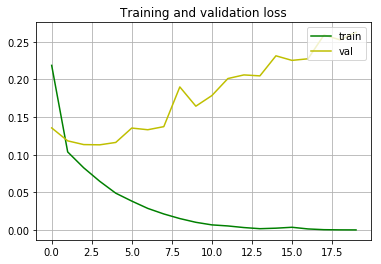

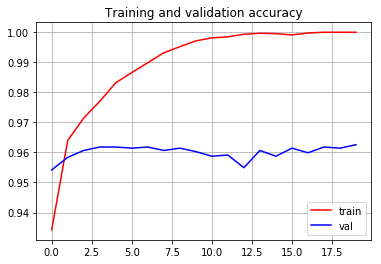

In [125]:
plot_loss_accu(h)